<a href="https://colab.research.google.com/github/victory256/Sample-ML-Repo/blob/hw05/%D0%AF%D0%BA%D1%83%D0%B1%D0%BE%D0%B2%D0%B0_hw05_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия

Обозначения:
- $\mathbb{X} \in \mathbb{R}^{n \times m}$ - матрица признаков
- $\mathbb{Y} \in \mathbb{R}^n$ - целевая переменная
- $x \in \mathbb{R}^{m}$ - один объект из выборки
- $\omega = (\omega_1,...,\omega_m)$ - вектор весов (параметров) модели
- $Q(f, \mathbb{Y})$ - функционал ошибок

Общий вид модели: $f(x, \omega) = \omega_0 + x_1\omega_1 + ... + x_m\omega_m = \sum\limits_{i=0}^{m}x_i\omega_i = <x, \omega>$



Функионал ошибок задачи линейной регрессии: $Q = MSE = \sum\limits_{i}(y_i-x_i^T \omega)^2 = ||\mathbb{Y} - \mathbb{X}\omega||_2^2$

<p style="text-align: center;">$\omega_{opt} = (\mathbb{X}^T\mathbb{X})^{-1}\mathbb{X}\mathbb{Y}$</p>

Найдём шаг градиентного спуска

$||\mathbb{Y} - \mathbb{X}\omega||_2^2 = <\mathbb{Y} - \mathbb{X}\omega, \mathbb{Y} - \mathbb{X}\omega>$

Дифференциал для векторной функции: $df(x)\big|_{x_0} = <\nabla f(x), x_0>$

Формула дифференциала скалярного произведения: $d(<u, v>)\big|_{\omega} = <d(u)|_{\omega}, v> + <u, d(v)|_{\omega}>$

$dQ\big|_{\omega_{*}} = 2<d(\mathbb{Y} - \mathbb{X}\omega)\big|_{\omega_{*}}, \mathbb{Y} - \mathbb{X}\omega>$

$dQ\big|_{\omega_{*}} = -2<\mathbb{Y} - \mathbb{X}\omega, \mathbb{X}\omega_{*}> = -2\mathbb{X}^T<\mathbb{Y} - \mathbb{X}\omega, \omega_{*}>$

$\nabla_{\omega}Q = -2\mathbb{X}^T(\mathbb{Y} - \mathbb{X}\omega) = 2\mathbb{X}^T(\mathbb{X}\omega - \mathbb{Y})$

___Задание 1___: 
- Реализовать свою модель линейной регрессии с регуляризацией и сравнить с моделью Ridge

В случае регуляризации функионал ошибок примет вид: $Q = ||\mathbb{Y} - \mathbb{X}\omega||_2^2 + \alpha||\omega||_2^2$

Найдем дифференциал от второго слагаемого $\alpha||\omega||_2^2 = \alpha <\omega, \omega>$

 $d(<\omega, \omega>)\big|_{\omega} = <d(\omega)|_{\omega}, \omega> + <\omega, d(\omega)|_{\omega}> = 2· <d(\omega)|_{\omega}, \omega> =2· <1, \omega> = 2· \omega   $

 Получаем 
$\nabla_{\omega}Q = 2\mathbb{X}^T(\mathbb{X}\omega - \mathbb{Y}) +  2\alpha· \omega $

In [1]:
from sklearn.base import BaseEstimator, RegressorMixin

class LinRegRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, alpha=1, batch_size=25, num_steps=350, lr=1e-2):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lr = lr
        self.alpha = alpha

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]      # переводим матрицу-строку в матрицу-столбец
        n_objects = len(X)      # кол-во объектов

        for i in range(self.num_steps):
            # выбираем self.batch_size объектов 
            sample_indices = np.random.randint(0, n_objects, size=self.batch_size)    
            # считаем вектор весов через градиентный спуск, чтобы не считать обратную матрицу признаков
            w -= 2 * self.lr * (
                np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices])     # MSE
                + self.alpha * w      # дополнительное слагаемое Регуляризации
                ) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w     # матрица признаков * вектор весов

Сравним написанную линейную регрессию с регуляризацией LinRegRidgeи с имеющейся в sklearn моделью Ridge. 

Для наглядности возьмем один признак и нанесем на плоскость. Сравним визуально предсказания, которые получаются по обеим моделям и посчитаем $R^2 score$.

R^2 in own model: 0.9662652703183835
R^2 in sklearn loss: 0.966655844380582


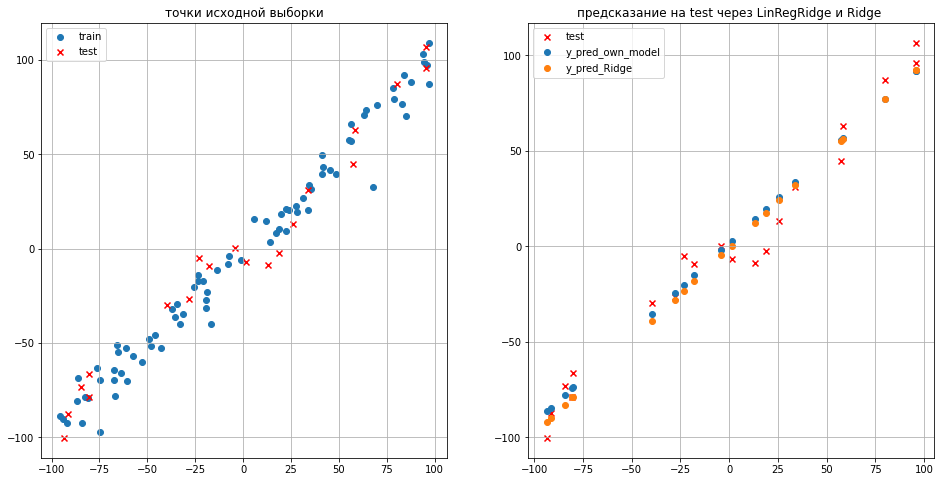

In [2]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Генерация данных для тестирования (один признак, чтобы визуально проверить)
n_features = 1
n_objects = 100

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) #* np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

# делим выборку на train и test
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

# нормализуем значения признаков
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# предсказываем на test значения
alpha = 1
own_model = LinRegRidge(alpha).fit(x_scaled, y_train)
y_pred_own_model = own_model.predict(x_test_scaled)
sklearn_model = Ridge(alpha).fit(x_scaled, y_train)
y_pred_Ridge = sklearn_model.predict(x_test_scaled)
# нарисуем 
print('R^2 in own model:', r2_score(y_test, y_pred_own_model))
print('R^2 in sklearn loss:', r2_score(y_test, y_pred_Ridge))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, label='train')
plt.scatter(x_test, y_test, label='test', marker='x', c='red')
plt.legend()
plt.grid()
plt.title("точки исходной выборки")
plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test, label='test', marker='x', c='red')
plt.scatter(x_test, y_pred_own_model, label='y_pred_own_model')
plt.scatter(x_test, y_pred_Ridge, label='y_pred_Ridge')
plt.legend()
plt.grid()
plt.title("предсказание на test через LinRegRidge и Ridge ")
plt.show()

Судя по графикам результат нашей линейной регрессии с регуляризацией LinRegRidge соответвует значениям Ridge. И $R^2 score$ совпадает в первых двух цифрах после запятой

Проверим для большего количества признаков. Визуально мы не проверим, но $R^2 score$ также совпадает в первых двух цифрах после запятой.

In [3]:
#Генерация данных для тестирования
n_features = 700
n_objects = 100000

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

# делим выборку на train и test
x_train, x_test, y_train, y_test = train_test_split(X, Y)

# нормализуем значения признаков
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# предсказываем на test значения
alpha = 1
own_model = LinRegRidge(alpha).fit(x_scaled, y_train)
y_pred_own_model = own_model.predict(x_test_scaled)
own_r2 = r2_score(y_test, y_pred_own_model)

sklearn_model = Ridge(alpha).fit(x_scaled, y_train)
y_pred_Ridge = sklearn_model.predict(x_test_scaled)

sklearn_r2 = r2_score(y_test, y_pred_Ridge)

print('R^2 in own model:', own_r2)
print('R^2 in sklearn loss:', sklearn_r2)

R^2 in own model: 0.9977946732450715
R^2 in sklearn loss: 0.9999999996137531


Сравним модели по $R^2 score$.

<p style="text-align: center;">$R^2 = 1 - \dfrac{\sum\limits_{i}(y_i - f(x_i, \omega))^2}{\sum\limits_{i}(y_i - y_{mean})^2}$</p>

$R^2 score$ показывает насколько наша модель хорошо описывает данные

# Линейная классификация

Рассмотрим задачу бинарной классификации, пусть целевая переменная $y_i \in \{+1, -1\}$

В задачах линейной классификации мы исходим из предположения о линейной разделимости выборки:

![lin_class](./lin_sample.jpeg)
<p style="text-align: center;"></p>

Исходя из этого, наша модель имеет вид:

___Ваш ответ___: sign(<x, w>)

# Обучение линейного классификатора

Введём функционал ошибок: $Q = \dfrac{1}{n}\sum\limits_{i=1}^{n}[f(x_i, \omega) \neq y_i]$ - плохо

$Q = \dfrac{1}{n}\sum\limits_{i=1}^{n}[f(x_i, \omega) \neq y_i] < \dfrac{1}{n}\sum\limits_{i=1}^{n}L(x_i, \omega, y_i)$

# Логистическая регрессия

Хотим предсказывать не класс нашего объекта, а вероятность, что он принадлежит к классу +1, то есть $f(x_i) = \mathbb{P}(y_i = +1 | x_i)$

Зададим функцию правдоподобия:

$\mathcal{L} = \prod\limits_{i=1}^{n}f(x_i)^{[y_i=+1]}(1-f(x_i))^{[y_i = -1]}$

$-log\mathcal{L} = -\sum\limits_{i=1}^{n}\big(  [y_i=+1]logf(x) + [y_i=-1]log(1 - f(x)) \big)$

$L = [y_i=+1]logf(x) + [y_i=-1]log(1 - f(x))$

$\sigma(x) = \dfrac{1}{1 + e^{-x}}$

![sigmoid](./sigmoid.png)
<p style="text-align: center;"></p>

Если в качестве $f(x)$ взять $f(x) = \sigma(<x, \omega>)$, то $log-loss = \dfrac{1}{n}\sum\limits_{i=1}^{n}log(1 + e^{y_i<x_i, \omega>})$ 

___Задание___: написать свою логистическую регрессию

Функционал ошибок имеет вид 
$Q = \dfrac{1}{n}\sum\limits_{i=1}^{n}L(x_i, \omega, y_i)$, где 

$L = - y_i \cdot logf(x) - (1-y_i) \cdot log(1 - f(x))$

$f(x) = \dfrac{1}{1 + e^{-<x, \omega>}}$

Найдем производную $$
\frac{\partial{L}}{\partial{w}}
= \left(-\frac{y_i}{f(x)} + \frac{1-y_i}{1-f(x)}\right)\frac{\partial{f(x)}}{\partial{w}} = \left(-\frac{y_i}{f(x)} + \frac{1-y_i}{1-f(x)}\right) \cdot f(x) \cdot (1-f(x)) \cdot x
$$

$$
= (-y_i \cdot (1-f(x)) + (1-y_i) \cdot f(x_i)) \cdot x = (f(x_i) - y_i) \cdot x
$$

$$
\frac{\partial{f(x)}}{\partial{w}}=\frac{e^{-<x, \omega>} \cdot x}{(1 + e^{-<x, \omega>})^2} = f(x) \cdot (1-f(x))  \cdot x
$$

 Получаем 
$\nabla_{\omega}Q = \mathbb{X}^T \cdot(\sigma(\mathbb{X}\omega) - \mathbb{Y}) $

In [4]:
class LogReg(BaseEstimator, RegressorMixin):
    
    def __init__(self, batch_size=25, num_steps=350, lr=1e-2):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lr = lr
    
    def sigmoid(self, x):
        return 1. / (1 + np.exp(-x))

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]      # переводим матрицу-строку в матрицу-столбец
        n_objects = len(X)      # кол-во объектов
        

        for i in range(self.num_steps):
            # выбираем self.batch_size объектов 
            sample_indices = np.random.randint(0, n_objects, size=self.batch_size)    
            # считаем вектор весов через градиентный спуск, чтобы не считать обратную матрицу признаков
            w -= self.lr * np.dot(X[sample_indices].T,
                                  self.sigmoid(np.dot(X[sample_indices], w))- Y[sample_indices][:, None]  
                                  )  / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.w)) >= 0.5    # sigmoid(матрица признаков * вектор весов)

Сравним написанную логистическую регрессии LogReg с LogisticRegression с имеющейся в sklearn. 

Для наглядности разделим расссматриваемую область на две половины (результат предсказания) и нанесем рассматриваемы точки на плоскость. Сравним визуально предсказания, которые получаются по обеим моделям и посчитаем $accuracy$.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  


accuracy in own model: 1.0
accuracy in sklearn logloss: 1.0


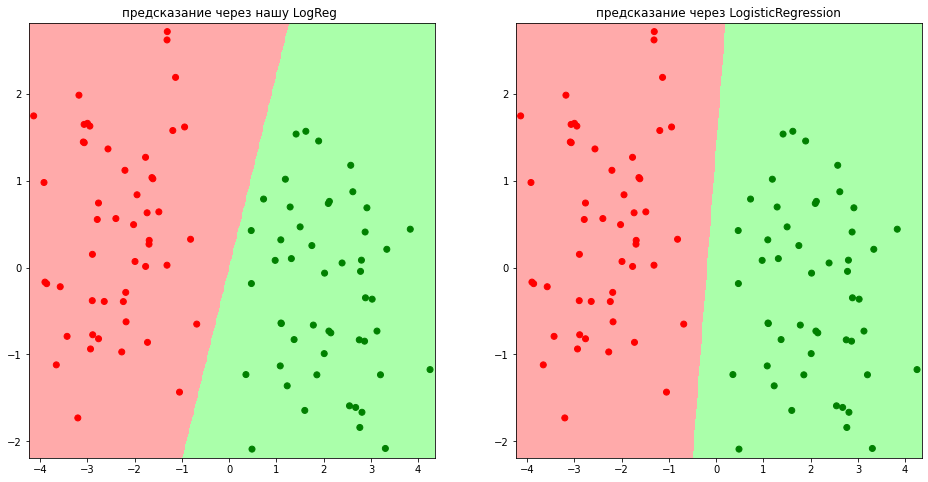

In [5]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Генерация данных для тестирования
n_samples = 100
X, y = make_blobs(n_samples=n_samples, centers=[[-2,0.5],[2,-0.5]])

colored_y = np.random.random_integers(low=0, high=1, size= n_samples)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])
    

own_model = LogReg()
own_model.fit(X, y)
# нарисуем 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))
# предсказываем 
Z = own_model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=colored_y)# отмечаем точки
plt.title("предсказание через нашу LogReg ")
plt.subplot(1, 2, 2)
plt.title("предсказание через LogisticRegression")
sklearn_model = LogisticRegression()
sklearn_model.fit(X, y)
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))
# предсказываем 
Z = sklearn_model.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=colored_y) # отмечаем точки

#считаем accuracy
print('accuracy in own model:', accuracy_score(y, own_model.predict(X).reshape(n_samples)))
print('accuracy in sklearn logloss:', accuracy_score(y, sklearn_model.predict(X)))

Судя по графикам деление на два класса нашей логистической регрессии LogReg соответвует результату LogisticRegression. И занчения $accuracy$ близки. 
Для нашего искуственного примера меры $accuracy$ достаточно, т.к. количество точек обоих классов одинаковое